# Work in Progress to plot results

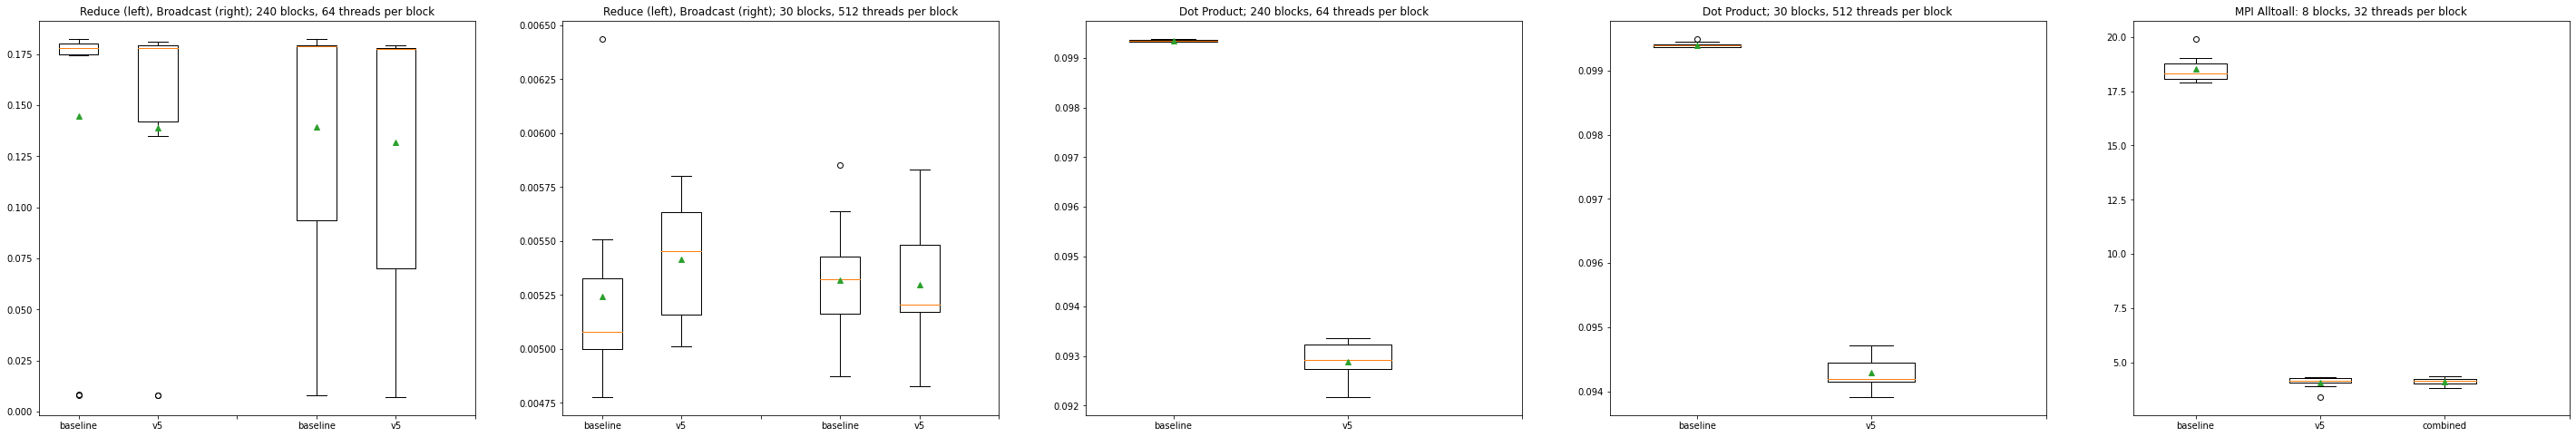

In [33]:
#!/usr/bin/env python
# coding: utf-8

# Plot benchmarks using existing run data

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import sys


#CSV_PATH = sys.argv[1]
CSV_PATH = "results/2021-12-22-00:07:41"

header = ['version', 'workload', 'run', 'blocks', 'threads', 'doubles', 'malloc', 'work', 'free']
df = pd.read_csv(CSV_PATH+"/out.csv", names = header, header = 0, delimiter = ' ', dtype={'malloc':float, 'work':float, 'free':float})
    
#df = df[(((df['doubles']==16) | (df['doubles']==64)) & ((df['blocks']==240) | (df['blocks']==30))) | (df['blocks']==8)]
# & ((df['version']=='baseline') | (df['version']=='v1_martin') | (df['version']=='v5_anton') | (df['version']=='combined_malloc'))]

def q95(x):
    return x.quantile(0.95)

def q5(x):
    return x.quantile(0.05)








# single plot
def plot_floats_vs_cycles(df, ax, params):
        
    # filter for data that fits the given parameters
    block_mask = df['blocks'] == params['blocks']
    threads_mask = df['threads'] == params['threads']
    workload_mask = df['workload'] == params['workload']
    df = df[block_mask & threads_mask & workload_mask]
    
    if params['doubles'] >= 0:
        float_mask = df['doubles'] <= params['doubles']
        df = df[float_mask]
    
    
    # calculate mean and std over all runs
    df = df.groupby(['version', 'workload', 'blocks', 'threads', 'doubles'], as_index=False)\
           .agg({'malloc':[q5,'median',q95],\
                 'free':[q5,'median',q95],\
                 'work':[q5,'median',q95]}\
               )
    
#     print(df[:10])
   
    floats = [16]# list(df['doubles'].unique())
    
    # select versions to plot
    if len(params['versions']) != 0:
        versions = params['versions']
    else:
        versions = list(df['version'].unique())
    
    # plot lines
    measurement_type = params['measurement_type'] # is either "malloc", "work", or "free"
    ax.set_title(measurement_type)
    # baseline reference
    reference_mean = df[df['version'] == versions[0]][measurement_type]['median']
    for version in versions:
        mean = df[df['version'] == version][measurement_type]['median']
#         mean = df[measurement_type]['median']
        #std = df[df['version'] == version][measurement_type]['std']
        
        
        # relative speedup to first version (baseline)
        if params['show_speedup']:
            speedup = np.asarray(reference_mean) / np.asarray(mean)
            ax.plot(floats, speedup, label=str(version))
            ax.set_ylabel("relative speedup")
        else:
#             ax.errorbar(floats, mean, std, label=str(version))
            if len(floats) != len(mean):
                print(version)
                continue    
            ax.plot(floats, mean, label=str(version), linestyle="",marker="o")
            ax.set_ylabel("seconds")
    
    ax.legend()
    ax.set_xlabel("#doubles")
    return
    

    
# extract range of parameters
versions = list(df['version'].unique())
workloads = list(df['workload'].unique())
runs = list(df['run'].unique())
blocks = list(df['blocks'].unique())
threads_per_block = list(df['threads'].unique())
num_floats = list(df['doubles'].unique())
measurement_types = ['malloc', 'work', 'free']

def plot_workloads_vs_measurement_type():
    ## plot (workloads) vs (malloc, work, free)
    fig, axs = plt.subplots(len(workloads), 3, sharey=False, sharex=True, figsize=(15, len(workloads)*5))
    
    fig.patch.set_facecolor("white")
    
    # constant parameters
    n_blocks = 240
    n_threads_per_block = 64
    n_floats = 4
    versions = [] # all
#     aggregation_type = 'mean' # or max
    show_speedup = False
    
    fig.suptitle("Parameters:" \
              + " blocks: " + str(n_blocks)\
              + ", threads per block: " + str(n_threads_per_block)\
#               + ", aggregation type: " + str(aggregation_type)\
              + ", runs: " + str(runs)\
#               + ", warmup runs: " + str(warmups) + ",\n"\
              + "workloads top-to-bottom: " + str(workloads))
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    for w, workload in enumerate(workloads):
        for i, measurement_type in enumerate(measurement_types):
            params = {'measurement_type': measurement_type,
                      'blocks': 240,
                      'threads': 64,
                      'workload': workload,
                      'doubles': n_floats,
                      'versions': versions,
#                       'aggregation_type': aggregation_type,
                      'show_speedup': show_speedup}
            if len(workloads) == 1:
                ax = axs[i]
            else:
                ax = axs[w][i]
            plot_floats_vs_cycles(df, ax, params)

    plt.savefig(CSV_PATH+"/workload_vs_measurement_type.png", dpi=60, bbox_inches='tight')   
    plt.show()

def plot_blocks_vs_threads_per_block():
    ## plot (blocks) vs (threads_per_block)
    fig, axs = plt.subplots(len(workloads), len(threads_per_block), sharey='row', sharex=True, figsize=(len(threads_per_block)*5, len(workloads)*5))
    
    if len(threads_per_block) == 1:
        axs = [axs]
    
    fig.patch.set_facecolor("white")
    
    # constant parameters
    n_floats = -1
    versions = ['baseline', 'v1', 'v4', 'v1_martin', 'v5_anton', 'combined_malloc']
#     aggregation_type = 'mean' # or max
    show_speedup = False
    
    fig.suptitle("Parameters:" \
#               + " aggregation type: " + str(aggregation_type)\
              + ", runs: " + str(runs)\
#               + ", warmup runs: " + str(warmups) + ",\n"\
              + "workloads top-to-bottom: " + str(workloads))
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    for w, workload in enumerate(workloads):
        for b, block in enumerate(blocks):
        
            params = {'measurement_type': 'work',
                      'blocks': block,
                      'threads': threads_per_block[b],
                      'workload': workload,
                      'doubles': n_floats,
                      'versions': versions,
#                       'aggregation_type': aggregation_type,
                      'show_speedup': show_speedup}
            if len(workloads) == 1:
                ax = axs[b]
            else:
                ax = axs[w][b]
            plot_floats_vs_cycles(df, ax, params)
            ax.grid(True)
#             ax.set_xscale("log", base=2)
#             ax.set_yscale("log", base=2)
            ax.set_title("Work ["+str(block)+", "+str(threads_per_block[b])+"]")

    plt.savefig(CSV_PATH+"/blocks_vs_threads_per_block_vs_workload.png", dpi=60, bbox_inches='tight')   
    plt.show()

def plot_boxplots_lines(df, ax, blocks, workloads):
    df = df[df['blocks']==blocks]
    
    df = df.groupby(['version', 'workload', 'blocks', 'threads', 'doubles'], as_index=False)\
       .agg({'malloc':[q5,'median',q95,'mean'],\
             'free':[q5,'median',q95,'mean'],\
             'work':[q5,'median',q95,'mean']})
    
    versions = ['baseline', 'v5_anton']
    labels = ['baseline', 'v5', '']
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
#     workloads = ['reduce', 'bcast', 'scalar_product', 'combined']

#     print(df)
    for i, wl in enumerate(workloads):
        data = []
        for v in versions:
            tmp = df[(df['workload']==wl) & (df['version']==v)]['work']['median']
            print(tmp)
            bp = ax.plot(range(len(versions)), data, label=v+'_'+wl)

#     ax.set_xticks(range((1+len(versions))*len(workloads)))
#     ax.set_xticklabels(labels*len(workloads))
    ax.legend()


def plot_boxplots(df, ax, blocks, workloads):
    df = df[df['blocks']==blocks]
    
    df = df.groupby(['version', 'workload', 'run', 'blocks', 'threads', 'doubles'], as_index=False)\
       .agg({'malloc':[q5,'median',q95,'mean'],\
             'free':[q5,'median',q95,'mean'],\
             'work':[q5,'median',q95,'mean']})

    
    versions = ['baseline', 'v5_anton']
    labels = ['baseline', 'v5', '']
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
#     workloads = ['reduce', 'bcast', 'scalar_product', 'combined']

#     print(df)
    for i, wl in enumerate(workloads):
        data = []
        for v in versions:
            tmp = []
            for el in df[(df['workload']==wl) & (df['version']==v)]['work']['median']:
                tmp.append(el)
            data.append(tmp)
#         print(data[:10])
#         print(len(data))
        bp = ax.boxplot(data, positions=np.array(range(len(data)))+i*(len(data)+1), widths=0.5, showmeans=True, showfliers=True)
#         plt.setp(bp['boxes'], color=colors[i])
#         ax.plot([], c=colors[i], label=wl)

    ax.set_xticks(range((1+len(versions))*len(workloads)))
    ax.set_xticklabels(labels*len(workloads))
    #ax.set_yscale('log', base=2)
#     ax.legend()
    
def plot_alltoall(df, ax):
    df = df[df['blocks']==8]
    
    df = df.groupby(['version', 'workload', 'run', 'blocks', 'threads', 'doubles'], as_index=False)\
       .agg({'malloc':[q5,'median',q95,'mean'],\
             'free':[q5,'median',q95,'mean'],\
             'work':[q5,'median',q95,'mean']})

    
    versions = ['baseline', 'v5_anton', 'combined_malloc']
    labels = ['baseline', 'v5', 'combined', '']
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
    workloads = ['alltoall']

#     print(df)
    for i, wl in enumerate(workloads):
        data = []
        for v in versions:
            tmp = []
            for el in df[(df['workload']==wl) & (df['version']==v)]['work']['median']:
                tmp.append(el)
            data.append(tmp)
#         print(data[:10])
#         print(len(data))
        bp = ax.boxplot(data, positions=np.array(range(len(data)))+i*(len(data)+1), widths=0.5, showmeans=True)
#         plt.setp(bp['boxes'], color=colors[i])
#         ax.plot([], c=colors[i], label=wl)

    ax.set_xticks(range(len(workloads)*(1+len(versions))))
    ax.set_xticklabels(labels*len(workloads))
#     ax.legend()
    
    
#plot_workloads_vs_measurement_type()
# plot_blocks_vs_threads_per_block()

fig, ax = plt.subplots(1,5,figsize=(50, 8))
ax[0].set_title("Reduce (left), Broadcast (right); 240 blocks, 64 threads per block")
ax[2].set_title("Dot Product; 240 blocks, 64 threads per block")
ax[1].set_title("Reduce (left), Broadcast (right); 30 blocks, 512 threads per block")
ax[3].set_title("Dot Product; 30 blocks, 512 threads per block")
ax[4].set_title("MPI Alltoall: 8 blocks, 32 threads per block")
plot_boxplots(df, ax[0], 240, ['reduce', 'bcast'])
plot_boxplots(df, ax[2], 240, ['scalar_product'])
plot_boxplots(df, ax[1], 30, ['reduce', 'bcast'])
plot_boxplots(df, ax[3], 30, ['scalar_product'])
plot_alltoall(df, ax[4])
plt.savefig(CSV_PATH+"/blocks_vs_threads_per_block_vs_workload.png", dpi=300, bbox_inches='tight')   
plt.show()